<a href="https://colab.research.google.com/github/omarjilanijidan/Iris-Cataract-Detection-From-Fundus-Images/blob/main/MobileNetV2_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [1]:
import os
import numpy as np
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

In [2]:
# Authenticate and mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_size = 224
dataset_dir = ""

In [4]:
def create_dataset(image_category, label):
    dataset = []
    labels = []
    image_folder = os.path.join(dataset_dir, image_category)
    for img in tqdm(os.listdir(image_folder)[:1000]):
        image_path = os.path.join(image_folder, img)
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if image is None:
                raise Exception("Failed to load image data")
            image = cv2.resize(image, (image_size, image_size))
            image = image / 255.0
            dataset.append(image)
            labels.append(label)
        except Exception as e:
            print(e)
    return np.array(dataset), np.array(labels)

In [5]:
cataract_images, cataract_labels = create_dataset("/content/drive/MyDrive/Papers/Dataset Fundus Image/Cataract", 1)
normal_images, normal_labels = create_dataset("/content/drive/MyDrive/Papers/Dataset Fundus Image/NDG", 0)

100%|██████████| 1000/1000 [01:36<00:00, 10.36it/s]


In [6]:
X = np.concatenate((cataract_images, normal_images[:1000]), axis=0)
y = np.concatenate((cataract_labels, normal_labels[:1000]), axis=0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Print number of images used for training and testing
print(f"Number of images used for training: {len(X_train)}")
print(f"Number of images used for testing: {len(X_test)}")

Number of images used for training: 1600
Number of images used for testing: 400


In [9]:
# Pre-augmentation
augmented_images = []
augmented_labels = []
#Augmentation training data
for image, label in zip(X_train, y_train):
    # Random rotation
    random_rotation = random.uniform(-20, 20)
    rotated_image = cv2.getRotationMatrix2D((image_size / 2, image_size / 2), random_rotation, 1)
    rotated_image = cv2.warpAffine(image, rotated_image, (image_size, image_size))
    augmented_images.append(rotated_image)
    augmented_labels.append(label)

    # Random horizontal flip
    if random.random() > 0.5:
        flipped_image = cv2.flip(image, 1)
        augmented_images.append(flipped_image)
        augmented_labels.append(label)

In [10]:
# Concatenate augmented images and labels with original data
X_train = np.concatenate((X_train, np.array(augmented_images)), axis=0)
y_train = np.concatenate((y_train, np.array(augmented_labels)), axis=0)

In [11]:
# Print number of images used for training and testing
print(f"Number of images used for training: {len(X_train)}")
print(f"Number of images used for testing: {len(X_test)}")

Number of images used for training: 4029
Number of images used for testing: 400


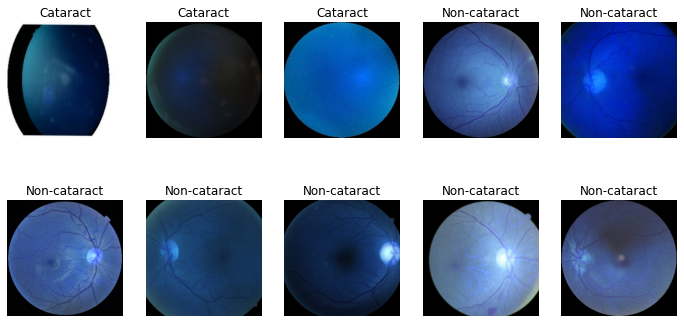

In [12]:
# Select 5 random cataract and non-cataract images
random_indices = np.random.choice(np.arange(len(y)), size=10, replace=False)
cataract_images = X[random_indices[y[random_indices] == 1]]
normal_images = X[random_indices[y[random_indices] == 0]]

# Concatenate cataract and non-cataract images
images = np.concatenate((cataract_images, normal_images))

# Create labels for cataract and non-cataract images
cataract_labels = ["Cataract" for _ in range(len(cataract_images))]
normal_labels = ["Non-cataract" for _ in range(len(normal_images))]

# Concatenate labels
labels = np.concatenate((cataract_labels, normal_labels))

# Create subplots with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Plot images in subplots
for ax, img, label in zip(axs.flatten(), images, labels):
    ax.imshow(img)
    ax.axis("off")
    ax.set(title=label)

plt.show()


In [13]:
# Create MobileNetV2 base model
mobilenet = MobileNetV2(include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
# Freeze base model layers
for layer in mobilenet.layers:
    layer.trainable = False

In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D

inputs = mobilenet.input
outputs = mobilenet.output
outputs = Dropout(0.5)(outputs)
outputs = Dense(512, activation="relu")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(49, activation="sigmoid")(outputs)
outputs = GlobalAveragePooling2D()(outputs)
predictions = Dense(1, activation="sigmoid")(outputs)
model = Model(inputs=inputs, outputs=predictions)

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [16]:
# Fit model on train data
history = model.fit(X_train, y_train, epochs=10, batch_size=49, validation_data=(X_test, y_test))

Epoch 1/10
83/83 [==============================] - 80s 913ms/step - loss: 0.1852 - accuracy: 0.9312 - val_loss: 0.0970 - val_accuracy: 0.9750
Epoch 2/10
83/83 [==============================] - 71s 856ms/step - loss: 0.0924 - accuracy: 0.9707 - val_loss: 0.0779 - val_accuracy: 0.9825
Epoch 3/10
83/83 [==============================] - 68s 820ms/step - loss: 0.0731 - accuracy: 0.9772 - val_loss: 0.0730 - val_accuracy: 0.9800
Epoch 4/10
83/83 [==============================] - 68s 814ms/step - loss: 0.0624 - accuracy: 0.9821 - val_loss: 0.0645 - val_accuracy: 0.9825
Epoch 5/10
83/83 [==============================] - 69s 833ms/step - loss: 0.0511 - accuracy: 0.9841 - val_loss: 0.0612 - val_accuracy: 0.9850
Epoch 6/10
83/83 [==============================] - 68s 817ms/step - loss: 0.0420 - accuracy: 0.9883 - val_loss: 0.0602 - val_accuracy: 0.9875
Epoch 7/10
83/83 [==============================] - 67s 810ms/step - loss: 0.0408 - accuracy: 0.9881 - val_loss: 0.0564 - val_accuracy: 0.9825

In [17]:
# Print maximum training accuracy
max_train_acc = max(history.history["accuracy"])
print(f"Maximum training accuracy: {max_train_acc:.4f}")

# Print maximum validation accuracy
max_val_acc = max(history.history["val_accuracy"])
print(f"Maximum validation accuracy: {max_val_acc:.4f}")

# Print minimum training loss
min_train_loss = min(history.history["loss"])
print(f"Minimum training loss: {min_train_loss:.4f}")

# Print minimum validation loss
min_val_loss = min(history.history["val_loss"])
print(f"Minimum validation loss: {min_val_loss:.4f}")

Maximum training accuracy: 0.9940
Maximum validation accuracy: 0.9900
Minimum training loss: 0.0268
Minimum validation loss: 0.0405


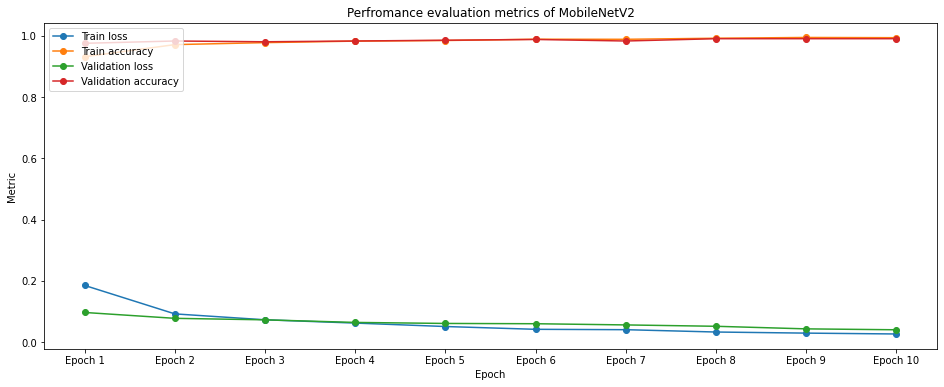

In [19]:
# Extract metric histories
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Create plot
fig, ax = plt.subplots(figsize=(16, 6))

# Get epoch names
epoch_names = ['Epoch {}'.format(i) for i in range(1, len(loss) + 1)]

# Plot loss, accuracy, validation loss, and validation accuracy as a combination of lines and dots over epochs
ax.plot(epoch_names, loss, '-o', label='Train loss')
ax.plot(epoch_names, acc, '-o', label='Train accuracy')
ax.plot(epoch_names, val_loss, '-o', label='Validation loss')
ax.plot(epoch_names, val_acc, '-o', label='Validation accuracy')

# Add legend and labels
ax.legend(loc='upper left')
ax.set_title('Perfromance evaluation metrics of MobileNetV2')
ax.set_ylabel('Metric')
ax.set_xlabel('Epoch')

plt.show()

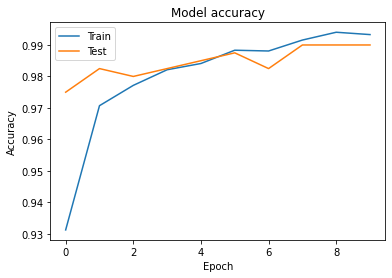

In [20]:
# Plot accuracy and loss during training
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

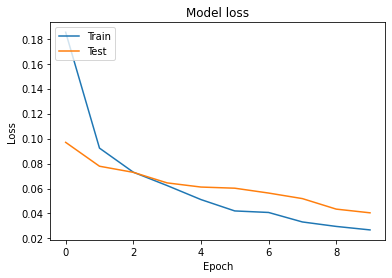

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

2/2 [==============================] - 2s 269ms/step


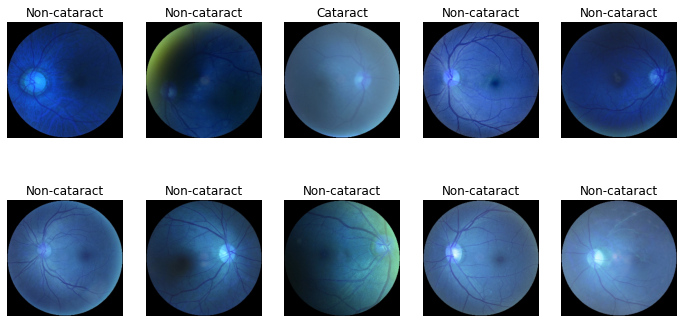

In [22]:
# Set test directory
test_dir = "/content/drive/MyDrive/Papers/Extra/preprocessed_images"

# Load test images
test_images = []
for img in os.listdir(test_dir)[:50]:
    image_path = os.path.join(test_dir, img)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (image_size, image_size))
    image = image / 255.0
    test_images.append(image)

# Convert test images to numpy array
test_images = np.array(test_images)

# Use model to predict labels for test images
predictions = model.predict(test_images)

# Create labels for test images
labels = ["Cataract" if prediction >= 0.5 else "Non-cataract" for prediction in predictions]

# Create subplots with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Plot test images in subplots
for ax, img, label in zip(axs.flatten(), test_images, labels):
    ax.imshow(img)
    ax.axis("off")
    ax.set(title=label)

plt.show()

In [23]:
# Get model evaluation on test data
evaluation = model.evaluate(X_test, y_test, verbose=0)

# Print model evaluation
print(f"Test loss: {evaluation[0]}")
print(f"Test accuracy: {evaluation[1]}")

Test loss: 0.040517374873161316
Test accuracy: 0.9900000095367432


In [24]:
from sklearn.metrics import confusion_matrix
# Make predictions on the test data
y_pred = model.predict(X_test)

# Threshold predictions to create a binary classification
y_pred = (y_pred > 0.5).astype(int)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate specificity
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
print("Specificity:", specificity)

13/13 [==============================] - 7s 478ms/step
Specificity: 0.9850746268656716


In [25]:
from sklearn.metrics import classification_report
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       201
           1       0.99      0.99      0.99       199

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [26]:
# Install latest version of mlxtend library
!pip install -U mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.0 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


(<Figure size 576x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1bdc4ce490>)

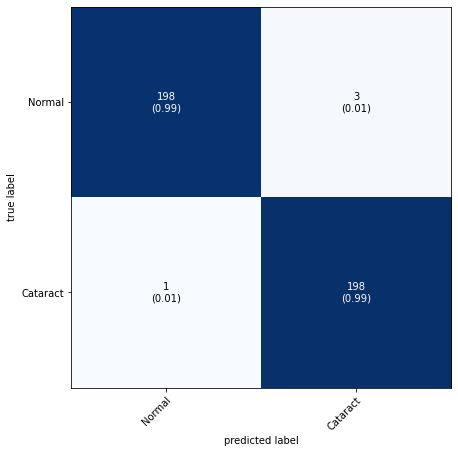

In [28]:
# Import plot_confusion_matrix function
from mlxtend.plotting import plot_confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plot_confusion_matrix(conf_mat=cm, figsize=(8,7), class_names=["Normal", "Cataract"], show_normed=True)